In [195]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import pickle
import itertools
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [109]:
test0 = pd.read_csv('data/Data/fungiclef2022/FungiCLEF2022_test_metadata.csv',sep = ',')

In [114]:
test0.head(3)

,Unnamed: 0,ObservationId,eventDate,month,day,countryCode,Location_lvl0,Location_lvl3,Location_lvl2,Location_lvl1,Substrate,Habitat,filename
0,0,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,0-3305985310.JPG
1,1,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,1-3305985310.JPG
2,2,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,2-3305985310.JPG


In [3]:
train_BigData = pd.read_csv('data/Data/fungiclef2022/DF20-train_metadata.csv',sep = ',')

In [4]:
train_BigData.head(3)


,gbifID,eventDate,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,...,level2Name,ImageUniqueID,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,class_id
0,2238546328,2018-04-16T00:00:00,2018.0,4.0,16.0,DK,Ulvedal Plantage,30872.0,Ramalina farinacea (L.) Ach.,Fungi,...,Viborg,2238546328-30620,bark of living trees,Ulfva Melchior Hvidegaard,56.299706,9.258110,50.0,Mixed woodland (with coniferous and deciduous ...,2238546328-30620.JPG,1273
1,2558871973,2020-01-03T00:00:00,2020.0,1.0,3.0,DK,Slotshegn,15256.0,Hysterium acuminatum Fr.,Fungi,...,Frederikssund,2558871973-53941,dead wood (including bark),Ole Martin,55.861899,11.975973,50.0,Deciduous woodland,2558871973-53941.JPG,708
2,2238503501,2017-08-22T00:00:00,2017.0,8.0,22.0,DK,Petersborg Strandenge,61200.0,Gliophorus perplexus (A.H.Sm. & Hesler) Kovalenko,Fungi,...,Vesthimmerland,2238503501-245559,soil,Per Taudal Poulsen,56.975158,9.285525,75.0,natural grassland,2238503501-245559.JPG,535


- During night we attempt to downsize the images from Big Data from the train data while keeping the labels

In [24]:
directory = 'data/Data/fungiclef2022/DF20-300px_train/DF20_300/' 
train_BigData['full_path_image'] = directory + train_BigData.image_path

In [25]:
# make a list of labels and directories
BIG_DATA_train = train_BigData.filter(['scientificName','image_path', 'full_path_image'], axis=1)
#downsize_in_batches()

In [40]:
BIG_DATA_train.full_path_image

0         data/Data/fungiclef2022/DF20-300px_train/DF20_...
1         data/Data/fungiclef2022/DF20-300px_train/DF20_...
2         data/Data/fungiclef2022/DF20-300px_train/DF20_...
3         data/Data/fungiclef2022/DF20-300px_train/DF20_...
4         data/Data/fungiclef2022/DF20-300px_train/DF20_...
                                ...                        
266339    data/Data/fungiclef2022/DF20-300px_train/DF20_...
266340    data/Data/fungiclef2022/DF20-300px_train/DF20_...
266341    data/Data/fungiclef2022/DF20-300px_train/DF20_...
266342    data/Data/fungiclef2022/DF20-300px_train/DF20_...
266343    data/Data/fungiclef2022/DF20-300px_train/DF20_...
Name: full_path_image, Length: 266344, dtype: object

In [47]:
def image_reshape_BD(dir, batch, new_size = (224,224),k = 300, gray =False):
    """
    works for Data from csv and random labels.
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized = []
    label = []
    for idx, dir in enumerate(dir[(batch-1)*k:batch * k],(batch-1)*k):     
        item = cv2.imread(dir)
        label.append(idx)
        if gray == True:
            item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
            item_resized_gray = resize(item_gray, new_size)
            items_resized.append(item_resized_gray)
        else:
            item_resized_colored = resize(item, new_size)
            items_resized.append(item_resized_colored)
    direct = 'data/Data/fungiclef2022/DF20-300px_train/' 
    with open(direct + "downsized/mushrooms_resized_part_"+ str(batch), "wb") as fp:   #Pickling
        pickle.dump(items_resized, fp)
    return items_resized, label
    
def downsize_in_batches(directories):
    """
    This function downsizes the images in batches of 300pics.
    directories = list of the directories of the images.
    """
    batch = 1
    for idx, dir in enumerate(directories):
        if idx % 300 == 0:
            print(batch)
            image_reshape_BD(directories,batch)
            batch += 1 


In [48]:
# make a list of labels and directories
downsize_in_batches(BIG_DATA_train.full_path_image)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


- END

- During night we attempt to downsize the images from Big Data from the valid data while keeping the labels

In [65]:
test_BigData = pd.read_csv('data/Data/fungiclef2022/FungiCLEF2022_test_metadata.csv',sep = ',')
test_BigData.head(2)

,Unnamed: 0,ObservationId,eventDate,month,day,countryCode,Location_lvl0,Location_lvl3,Location_lvl2,Location_lvl1,Substrate,Habitat,filename
0,0,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,0-3305985310.JPG
1,1,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,1-3305985310.JPG


In [70]:
directory = 'data/Data/fungiclef2022/DF21-images-300_val/DF21_300/' 
test_BigData['full_path_image'] = directory + test_BigData.filename

In [71]:
# make a list of labels and directories
BIG_DATA_test = test_BigData.filter(['ObservationId','filename', 'full_path_image'], axis=1)
#downsize_in_batches()

In [72]:
def image_reshape_BD(dir, batch, new_size = (224,224),k = 300, gray =False):
    """
    works for Data from csv and random labels.
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized = []
    label = []
    for idx, dir in enumerate(dir[(batch-1)*k:batch * k],(batch-1)*k):     
        item = cv2.imread(dir)
        label.append(idx)
        if gray == True:
            item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
            item_resized_gray = resize(item_gray, new_size)
            items_resized.append(item_resized_gray)
        else:
            item_resized_colored = resize(item, new_size)
            items_resized.append(item_resized_colored)
    direct = 'data/Data/fungiclef2022/DF21-images-300_val/' 
    with open(direct + "downsized/mushrooms_resized_part_"+ str(batch), "wb") as fp:   #Pickling
        pickle.dump(items_resized, fp)
    return items_resized, label
    
def downsize_in_batches(directories):
    """
    This function downsizes the images in batches of 300pics.
    directories = list of the directories of the images.
    """
    batch = 1
    for idx, dir in enumerate(directories):
        if idx % 300 == 0:
            print(batch)
            image_reshape_BD(directories,batch)
            batch += 1 


In [73]:
# make a list of labels and directories
downsize_in_batches(BIG_DATA_test.full_path_image)

1


Premature end of JPEG file


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

- END

- From Big Data mushrooms we have two lists, splitted in test and validation.
- - 1604 kinds of fungis
- - 266344 / 19594 , test/ val


- Smalll data set
- - Categories : 'Agaricus' : 0,'Amanita' : 1,'Boletus' : 2,'Cortinarius' : 3,'Entoloma' : 4,'Hygrocybe' : 5,
    'Lactarius' : 6,'Russula' : 7,'Suillus' : 8
- - number of pics per category: [352, 749, 1072, 835, 363, 315, 1562, 1147, 310]

# Day-1
- Work on the small data set.
- - make batches of downsize files
- - see issue with the premature end of JPEG
- - - make model run with 300 img per category
- - - make model work for 1000 pics per category using augmentation.Keras

In [243]:
def getList(dict):
    """
    This function returns the list of keys in a dictionary
    """
    return dict.keys()


CLASSES = {'Agaricus' : 0,'Amanita' : 1,'Boletus' : 2,'Cortinarius' : 3,'Entoloma' : 4,'Hygrocybe' : 5,
    'Lactarius' : 6,'Russula' : 7,'Suillus' : 8
                }

def get_label(key ,class_mush = CLASSES):
    """
    You can get the labeled name of the mushroom by giving 
    the index or the index by giving the key
    """
    if type(key) == str:
        return class_mush[key]
    elif type(key) == int:
        return list(CLASSES.keys())[list(CLASSES.values()).index(key)]


def upload_dir_labels(directory,mapping =CLASSES, k = 300):
    """
    give the list of photos from directory and the labels.
    k = number of pictures I want to take from each FOLDER. 
    """
    label = []
    dir= []
    list_of_mushrooms = getList(mapping)
    for f in list_of_mushrooms:
        pictures_dir = directory + f + '/'
        pictures = [pics for pics in listdir(pictures_dir) if isfile(join(pictures_dir , pics))]
        for idx, picture in enumerate(pictures[:k]): # take the first 300 pictures from each category
            label.append(get_label(f))  
            dir.append(pictures_dir + picture) 
        
    return dir, label

def image_reshape(dir, batch, new_size = (224,224),k = 300, gray =False):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized = []
    for idx, dir in enumerate(dir[(batch-1)*k:batch * k]):     
        item = cv2.imread(dir)
        if gray == True:
            item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
            item_resized_gray = resize(item_gray, new_size)
            items_resized.append(item_resized_gray)
        else:
            item_resized_colored = resize(item, new_size)
            items_resized.append(item_resized_colored)
    with open(directory + "downsized/mushrooms_resized_part_"+ str(batch), "wb") as fp:   #Pickling
        pickle.dump(items_resized, fp)
    return items_resized
    

def downsize_in_batches(directories):
    """
    This function downsizes the images in batches of 300pics.
    directories = list of the directories of the images.
    """
    batch = 1
    for idx, dir in enumerate(directories):

        if idx % 300 == 0:
            print(batch)
            image_reshape(directories,batch)
            batch += 1 


def unpickle(directory , mapping):
    """
    This functions takes the data from a directory that have been
    downsized in banches ang gives back the X,y as arrays.
    """
    
    table_mushrooms_downsized = []
    directories, labels = upload_dir_labels(directory,mapping, k=300)
    for batch in range(1,10): # 10 is the number of batches
        with open(directory + "downsized/mushrooms_resized_part_"+ str(batch), "rb") as fp:   # Unpickling
            li = pickle.load(fp)
            table_mushrooms_downsized.append(li)

    # flatten the nested list into a 1D list
    mushrooms_downsized = list(itertools.chain(*table_mushrooms_downsized))
    if len(mushrooms_downsized) == len(labels):

        #Check if the number of pictures and labels are the same.
        X = np.asarray(mushrooms_downsized)
        y = np.asarray(labels)

    return X, y

def isqrt(n):
    """
    This returns the largest integer x for which x * x does not exceed n. 
    If you want to check if the result is exactly the square root, simply 
    perform the multiplication to check if n is a perfect square.
    """
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x
def plot_mushroom_coll(x = 25):
    """
    We can see a collection of random mushrooms with the labels
    x is the number of mushrooms you want to see and it will give 
    the appropriate number of n * n array.
    """
    for i in range(x):
        ran = random.randint(0,len(y)-1)
        plt.subplot(int(np.sqrt(x)), int(np.sqrt(x)), i+1)
        plt.imshow(X[ran], cmap='Greys')
        plt.axis('off')
        plt.text(0, 0, y[ran]) # displays y-values in each subplot

def pickle_(directory, file):
    """
    This function pickles the data.
    """
    with open(directory , "wb") as fp:   #Pickling
        pickle.dump(file, fp)



def split_preprocessed_data(X ,y, test_size = 0.1, pp = False):
    """
    This function returns the train and validataion data 
    preprocessed if necessary: in a flattened 1_D form
    with normalized X and y per 255.
    Split images (75%/15%/10%) and save to temporary folders
    """
    if pp == True:
        x= X.reshape(X.shape[0],-1)
        x_norm = x.astype("float32") / 255 # Scale images to the [0, 1] range IF not scaled
        # one-hot-encode labels
        y_ohe = to_categorical(y)
        X_train, X_test, y_train, y_test = train_test_split(x_norm, y_ohe, test_size = test_size, random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size * 1.7, random_state=42) 
    else:
        x_norm = X.astype("float32") 
        # one-hot-encode labels
        y_ohe = to_categorical(y)
        X_train, X_test, y_train, y_test = train_test_split(x_norm, y_ohe, test_size = test_size, random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size * 1.7, random_state=42)  
    file_name = '/data/Data/Mushrooms/'
    
    pickle_(file_name + "train", X_train)
    pickle_(file_name + "train", y_train)
    pickle_(file_name + "test",  X_test)
    pickle_(file_name + "test",  y_test)
    pickle_(file_name + "valid", X_valid)
    pickle_(file_name + "valid", y_valid)  
    return X_train, X_test, y_train, y_test, X_valid, y_valid


In [192]:
# make a list of labels and directories
# Run to create batches labels etc
directory = 'data/Data/Mushrooms/' 
directories, labels = upload_dir_labels(directory, k=300)
downsize_in_batches()


1
2
3
4
5
6
7
8


Premature end of JPEG file


9


- took 2 min and 36 sec for batches of 300 pictures per categories (300*300pixs)
- took 3 min and 12 sec for batches of 300 pictures per categories (224*224pixs)

In [247]:
# Run to unpicle data and give back X,y
X ,y = unpickle(directory = 'data/Data/Mushrooms/' , mapping =CLASSES)

In [248]:
print(X[0])
G = X[0].astype("float32") / 255
print(G)

[[[0.86440576 0.92322929 0.93835534]
  [0.82660064 0.89220938 0.94206933]
  [0.85419668 0.90741797 0.96231993]
  ...
  [0.04048119 0.23428746 0.20241722]
  [0.03747249 0.24811675 0.19233318]
  [0.06173845 0.24225565 0.19619223]]

 [[0.85334384 0.91216737 0.93573054]
  [0.83582308 0.89859944 0.95652136]
  [0.84144908 0.8963823  0.94969738]
  ...
  [0.09465161 0.2851278  0.26651786]
  [0.04366622 0.25568102 0.19159664]
  [0.06753451 0.27080707 0.19844188]]

 [[0.83179397 0.89900335 0.94107643]
  [0.78290316 0.85540216 0.92093087]
  [0.8101228  0.86893758 0.92439976]
  ...
  [0.1378714  0.33130502 0.32570278]
  [0.06046919 0.28454132 0.20701781]
  [0.04648109 0.28839786 0.18437875]]

 ...

 [[0.00119423 0.01967287 0.04159539]
  [0.00368272 0.04569953 0.07315051]
  [0.02574405 0.07041442 0.10010629]
  ...
  [0.03318327 0.17392957 0.133741  ]
  [0.10913615 0.28454757 0.22706583]
  [0.06660539 0.36408063 0.26153336]]

 [[0.02567152 0.05778937 0.07453356]
  [0.05315126 0.10354017 0.13077231]


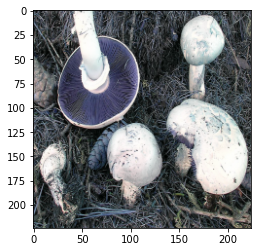

In [223]:
plt.imshow(X[0],cmap='Greys')

In [ ]:
plt.imshow(G,cmap='Greys')

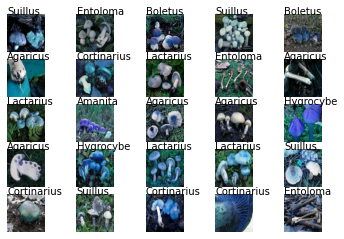

In [138]:
plot_mushroom_coll(x = 25)

- Prepare data to go inside the CNN models

- flatten data and normalize them to be in 0 to 1 intensity depending on the requirements of the model

In [242]:
X_train, X_test, y_train, y_test, X_valid, y_valid = split_preprocessed_data(X,y, pp = False)

# FIX THE BLACK SCREEN BAG

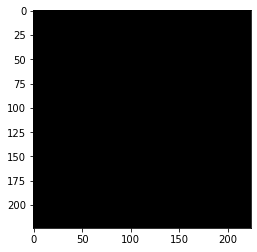

In [244]:
plt.imshow(X_train[0],cmap='Greys')

# END

- model RESNET_V2

In [106]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

In [ ]:
def model_ResNet50V2(CLASSES = CLASSES,learning_rate=0.001):
    """
    This function returns a ResNet50V2 model with the last
    layer removed.
    """
    K.clear_session() # Always clear the session!

    base_model = ResNet50V2(
        weights='imagenet', 
        pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
        include_top=False,   # !!!!! we only want to have the base, not the final dense layers 
        input_shape=(224, 224, 3)  
    )
    base_model.trainable = False # To freeze the model
    # Start building on top of the model
    model = keras.Sequential() # defining a new model
    model.add(base_model) # adding in the pretrained model without the fully connected layer
    model.add(keras.layers.Dense(64, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu')) # adding in additional layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(len(CLASSES), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
    # have a look at the trainable and non-trainable params statistic
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

def fit_ResNet50V2(X_train, y_train,epochs = 50, batch_size =500,sav = False):
    """
    This function fits the model on the training data.
    """
    # observe the validation loss and stop when it does not improve after 3 iterations
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(X_train, y_train, 
              epochs=epochs, 
              verbose=2,
              batch_size=batch_size, 
              callbacks=[callback],
              # use 30% of the data for validation
              validation_split=0.3)
    # save model
    if sav == True:
        model.save('models/ResNet50V2_RGB_300fot_SD.h5')
        
    return history

In [141]:
model = model_ResNet50V2()

history = fit_ResNet50V2(X_train, y_train, epochs = 50, batch_size =500)

Epoch 1/50
16/16 - 289s - loss: 2.2148 - categorical_accuracy: 0.1190 - val_loss: 2.1872 - val_categorical_accuracy: 0.1543 - 289s/epoch - 18s/step
Epoch 2/50
16/16 - 227s - loss: 2.1868 - categorical_accuracy: 0.1468 - val_loss: 2.1840 - val_categorical_accuracy: 0.1620 - 227s/epoch - 14s/step
Epoch 3/50
16/16 - 215s - loss: 2.1778 - categorical_accuracy: 0.1402 - val_loss: 2.1748 - val_categorical_accuracy: 0.1574 - 215s/epoch - 13s/step
Epoch 4/50
16/16 - 211s - loss: 2.1799 - categorical_accuracy: 0.1376 - val_loss: 2.1741 - val_categorical_accuracy: 0.1435 - 211s/epoch - 13s/step
Epoch 5/50
16/16 - 211s - loss: 2.1688 - categorical_accuracy: 0.1548 - val_loss: 2.1722 - val_categorical_accuracy: 0.1559 - 211s/epoch - 13s/step
Epoch 6/50
16/16 - 200s - loss: 2.1618 - categorical_accuracy: 0.1521 - val_loss: 2.1618 - val_categorical_accuracy: 0.1852 - 200s/epoch - 13s/step
Epoch 7/50
16/16 - 174s - loss: 2.1566 - categorical_accuracy: 0.1720 - val_loss: 2.1637 - val_categorical_accur

In [143]:
model.evaluate(X_train,y_train)

68/68 [==============================] - 336s 5s/step - loss: 1.9945 - categorical_accuracy: 0.2810


[1.9945423603057861, 0.28101852536201477]

In [144]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.0715527534484863
Test accuracy: 0.21851852536201477


# Try the augmentation
- increase data to 500

In [161]:
def print_num_pix_per_category(label):
    """
    This function prints the number of pictures per category of mushrooms
    label = list of numbers 0- len(classes)
    """
    res = list(set(label))
    for value in list(set(label)):
        print(f"There are {label.count(value)} values in the mushroom category {get_label(value)}")


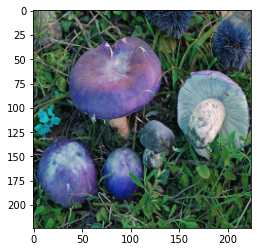

In [227]:
plt.imshow(X_train[0],cmap='Greys')

In [224]:
# find one random image and the corresponding label
image = X_train[0]
label_name = get_label( int(np.where(y_train[0] == 1)[0]))

TypeError: only size-1 arrays can be converted to Python scalars

In [228]:
data_augmentation = keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
])

In [229]:
# Add the image to a batch.
image = X_train[0]
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

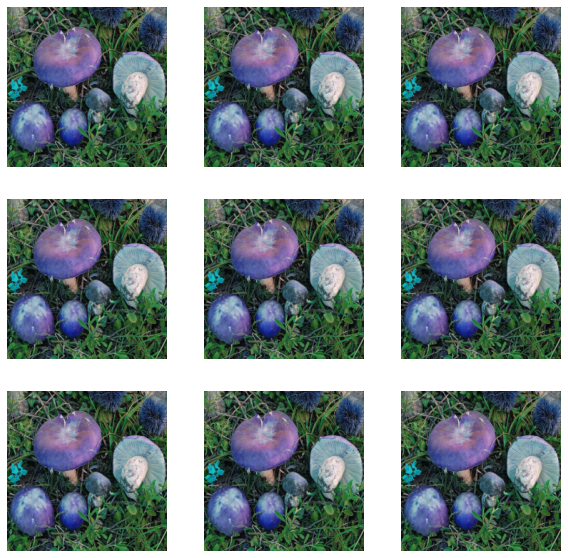

In [230]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [221]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

x = X[0]
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
plt.figure(figsize=(10, 10))
for batch in datagen.flow(x, batch_size=1,
        save_to_dir='augmentation', save_prefix='test', save_format='jpg'):     
        print(pd.size(batch))
        i += 1
        if i > 9:
                break  # otherwise the generator would loop indefinitel

AttributeError: module 'pandas' has no attribute 'size'

<Figure size 720x720 with 0 Axes>

In [222]:
X[0]

array([[[0.86440576, 0.92322929, 0.93835534],
        [0.82660064, 0.89220938, 0.94206933],
        [0.85419668, 0.90741797, 0.96231993],
        ...,
        [0.04048119, 0.23428746, 0.20241722],
        [0.03747249, 0.24811675, 0.19233318],
        [0.06173845, 0.24225565, 0.19619223]],

       [[0.85334384, 0.91216737, 0.93573054],
        [0.83582308, 0.89859944, 0.95652136],
        [0.84144908, 0.8963823 , 0.94969738],
        ...,
        [0.09465161, 0.2851278 , 0.26651786],
        [0.04366622, 0.25568102, 0.19159664],
        [0.06753451, 0.27080707, 0.19844188]],

       [[0.83179397, 0.89900335, 0.94107643],
        [0.78290316, 0.85540216, 0.92093087],
        [0.8101228 , 0.86893758, 0.92439976],
        ...,
        [0.1378714 , 0.33130502, 0.32570278],
        [0.06046919, 0.28454132, 0.20701781],
        [0.04648109, 0.28839786, 0.18437875]],

       ...,

       [[0.00119423, 0.01967287, 0.04159539],
        [0.00368272, 0.04569953, 0.07315051],
        [0.02574405, 0

In [205]:
np.size(X[0])

150528